In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib
import os

# 1️⃣ Load the dataset
path = "./data/processed.cleveland.data"
df = pd.read_csv(path)
df.head()
df.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'	
]
df.head()
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
hd            int64
dtype: object

In [96]:

# 3️⃣ Replace '?' with NaN and strip spaces
df = df.replace('?', np.nan).applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 4️⃣ Convert problematic columns to numeric
for col in ['ca', 'thal']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5️⃣ Fill NaN values with median (safe for numeric)
df.fillna(df.median(numeric_only=True), inplace=True)

# 6️⃣ Convert any remaining object columns to numeric (if convertible)
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            df[col] = df[col].astype('category').cat.codes

# 7️⃣ One-hot encode non-numeric categorical columns (if any)
df = pd.get_dummies(df, drop_first=True)

C:\Users\Saivamshi\AppData\Local\Temp\ipykernel_304\98626827.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.replace('?', np.nan).applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [99]:
df.loc[(df['ca'] == '?')
           |
           (df['thal'] == '?')]
df_with_no_missing = df.loc[(df['ca'] != '?')
                        &
                        (df['thal'] != '?')]
df_with_no_missing.info()

df_with_no_missing['cp'].unique()
df_with_no_missing.to_csv("./data/processed_cleveland_data.csv", index=False)
X = df_with_no_missing.drop('hd', axis=1).copy()
X.head()
y = df_with_no_missing['hd'].copy()
y.head()
numerical_cols = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak']
categorical_cols = ['restecg', 'slope', 'thal', 'ca', 'cp'] # We will pass this through OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),                  # Keep numerical columns as is
        ('cat', OneHotEncoder(drop='first'), categorical_cols)   # One-hot encode categorical columns
    ]
)
# Fit the preprocessor
preprocessor.fit(X_train)

# Save to file
joblib.dump(preprocessor, "./data/preprocessor.pkl")
print("✅ Preprocessor saved as preprocessor.pkl")

y.unique()
y_not_zero = y > 0
y[y_not_zero] = 1
y.unique()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    float64
 12  thal      302 non-null    float64
 13  hd        302 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 35.4 KB


ValueError: Specifying the columns using strings is only supported for dataframes.

In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
import os

# -----------------------------
# 1️⃣ Load the dataset
# -----------------------------
path = "./data/processed.cleveland.data"
df = pd.read_csv(path, header=None)
df.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'
]

# -----------------------------
# 2️⃣ Clean the dataset
# -----------------------------
# Replace '?' with NaN and strip spaces
df = df.replace('?', np.nan).applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Convert 'ca' and 'thal' to numeric
for col in ['ca', 'thal']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill NaN with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Convert any remaining object columns to numeric if possible
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            df[col] = df[col].astype('category').cat.codes

# Save cleaned dataset
os.makedirs("./data", exist_ok=True)
df.to_csv("./data/processed_cleveland_data.csv", index=False)
print("✅ Cleaned dataset saved")

# -----------------------------
# 3️⃣ Define features and target
# -----------------------------
X = df.drop('hd', axis=1)
y = df['hd'].copy()

# Convert target to binary (0 = no disease, 1 = disease)
y = (y > 0).astype(int)

# -----------------------------
# 4️⃣ Split dataset
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5️⃣ Define columns for preprocessing
# -----------------------------
numerical_cols = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak']
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']

# -----------------------------
# 6️⃣ Create and fit preprocessor
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),  # numeric columns stay as-is
        ('cat', OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore'), categorical_cols)  # one-hot encode
    ]
)
preprocessor.fit(X_train)

# Save preprocessor
joblib.dump(preprocessor, "./data/preprocessor.pkl")
print("✅ Preprocessor saved successfully")

# -----------------------------
# 7️⃣ Train XGBoost model
# -----------------------------
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train_transformed, y_train)

# Evaluate
accuracy = model.score(X_test_transformed, y_test)
print(f"✅ Model trained successfully — Accuracy: {accuracy:.4f}")

# Save model
joblib.dump(model, "./data/xgb_heart_model.pkl")
print("✅ Trained XGBoost model saved as xgb_heart_model.pkl")


✅ Cleaned dataset saved
✅ Preprocessor saved successfully
✅ Model trained successfully — Accuracy: 0.8852
✅ Trained XGBoost model saved as xgb_heart_model.pkl


C:\Users\Saivamshi\AppData\Local\Temp\ipykernel_304\2137441645.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.replace('?', np.nan).applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [78]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Confusion Matrix:
 [[27  5]
 [ 4 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.83      0.86      0.85        29

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

ROC AUC Score: 0.8814655172413793


In [77]:
df = pd.get_dummies(df, drop_first=True)
# 6️⃣ Save the preprocessed dataset (ready for model training)
os.makedirs("./data", exist_ok=True)
processed_path = "./data/processed_cleaned_noww.csv"
df.to_csv(processed_path, index=False)
print(f"✅ Cleaned dataset saved to {processed_path}")

# 7️⃣ Train XGBoost model
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# 8️⃣ Evaluate model
accuracy = model.score(X_test, y_test)
print(f"✅ Model trained successfully — Accuracy: {accuracy:.4f}")

# 9️⃣ Save trained model
model_path = "./data/xgb_heart_model.pkl"
joblib.dump(model, model_path)
print(f"✅ Trained XGBoost model saved to {model_path}")


✅ Cleaned dataset saved to ./data/processed_cleaned_noww.csv
✅ Model trained successfully — Accuracy: 0.8525
✅ Trained XGBoost model saved to ./data/xgb_heart_model.pkl


Cross-Validation Accuracy: 0.8159

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86        33
           1       0.93      0.76      0.83        33

    accuracy                           0.85        66
   macro avg       0.86      0.85      0.85        66
weighted avg       0.86      0.85      0.85        66



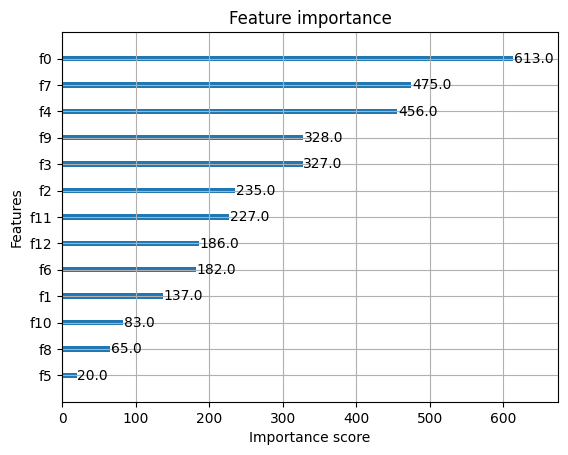

In [81]:


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Train-test split again
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Re-train model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f}")

# Evaluate again
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
import xgboost as xgb

xgb.plot_importance(model)
plt.show()


### Data Reading

In [5]:
df = pd.read_csv('./data/processed.cleveland.data', header=None)

In [ ]:
df.head()

No labels for the columns, so we name them. Refer: https://archive.ics.uci.edu/dataset/45/heart+disease

In [10]:
df.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'	
]
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Dealing with Missing Data

In [11]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
hd            int64
dtype: object

`ca` and `thal` have type object, it means that they have mixed types of values

In [12]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [13]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

As we can see above, in the last place there is a '?' symbol, which indicates missing value and is responsible for converting it to type *object*

In [14]:
# Number of rows that have missing values in the column of 'ca' and 'thal' 
len(df.loc[(df['ca'] == '?')
           |
           (df['thal'] == '?')])

6

In [15]:
df.loc[(df['ca'] == '?')
           |
           (df['thal'] == '?')]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


There are 6 rows that have one missing value, since they are so less (as compared to 302) from the whole dataset, we can simply remove them without affecting much of the actual output

In [16]:
df_with_no_missing = df.loc[(df['ca'] != '?')
                        &
                        (df['thal'] != '?')]

In [17]:
df_with_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    object 
 12  thal      297 non-null    object 
 13  hd        297 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 34.8+ KB


In [18]:
df_with_no_missing['cp'].unique()

array([1., 4., 3., 2.])

As we can see, the rows with missing values are removed (total rows are 297 now), however the columns 'ca' and 'thal' still have dtypes as *objects*

In [25]:
# Saving this Data
df_with_no_missing.to_csv("./data/processed_cleveland_data.csv", index=False)

### Splitting the Data

In [26]:
# Independent Variables
X = df_with_no_missing.drop('hd', axis=1).copy()
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [27]:
y = df_with_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

In [29]:
numerical_cols = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak']
categorical_cols = ['restecg', 'slope', 'thal', 'ca', 'cp'] # We will pass this through OneHotEncoder

**One Hot Encoding** the categorical variables

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),                  # Keep numerical columns as is
        ('cat', OneHotEncoder(drop='first'), categorical_cols)   # One-hot encode categorical columns
    ]
)

**Changing the values of 'y'**

In [32]:
y.unique()

array([0, 2, 1, 3, 4])

Since we only want to classify, whether the person has heart disease or not, we need 2 classifications only i.e. `1 or 0`. So we will convert all the non-zero values as one, as we do need to calculate the intensity

In [34]:
y_not_zero = y > 0
y[y_not_zero] = 1
y.unique()

array([0, 1])

_Split into train and test_

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Needed LATER in api coding for the schema
X_train.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
dtype: object

In [37]:
print(X_train['thal'].unique())

['3.0' '7.0' '6.0']


In [57]:
df.to_csv("./data/trained_csv.csv", index=False)

### Build a Preliminary Classification Tree

In [38]:
# Fit and transform the data using the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [39]:
print(type(X_train_transformed))
print(type(X_test_transformed))
print(type(y_train))
print(type(y_test))
print(type(preprocessor))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [40]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_transformed, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Evaluate the model**

In [41]:
train_score = dt_model.score(X_train_transformed, y_train)
test_score = dt_model.score(X_test_transformed, y_test)

print(f"Training Accuracy: {train_score:.2f}")
print(f"Testing Accuracy: {test_score:.2f}")

Training Accuracy: 1.00
Testing Accuracy: 0.72


**Plot it**

In [42]:
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

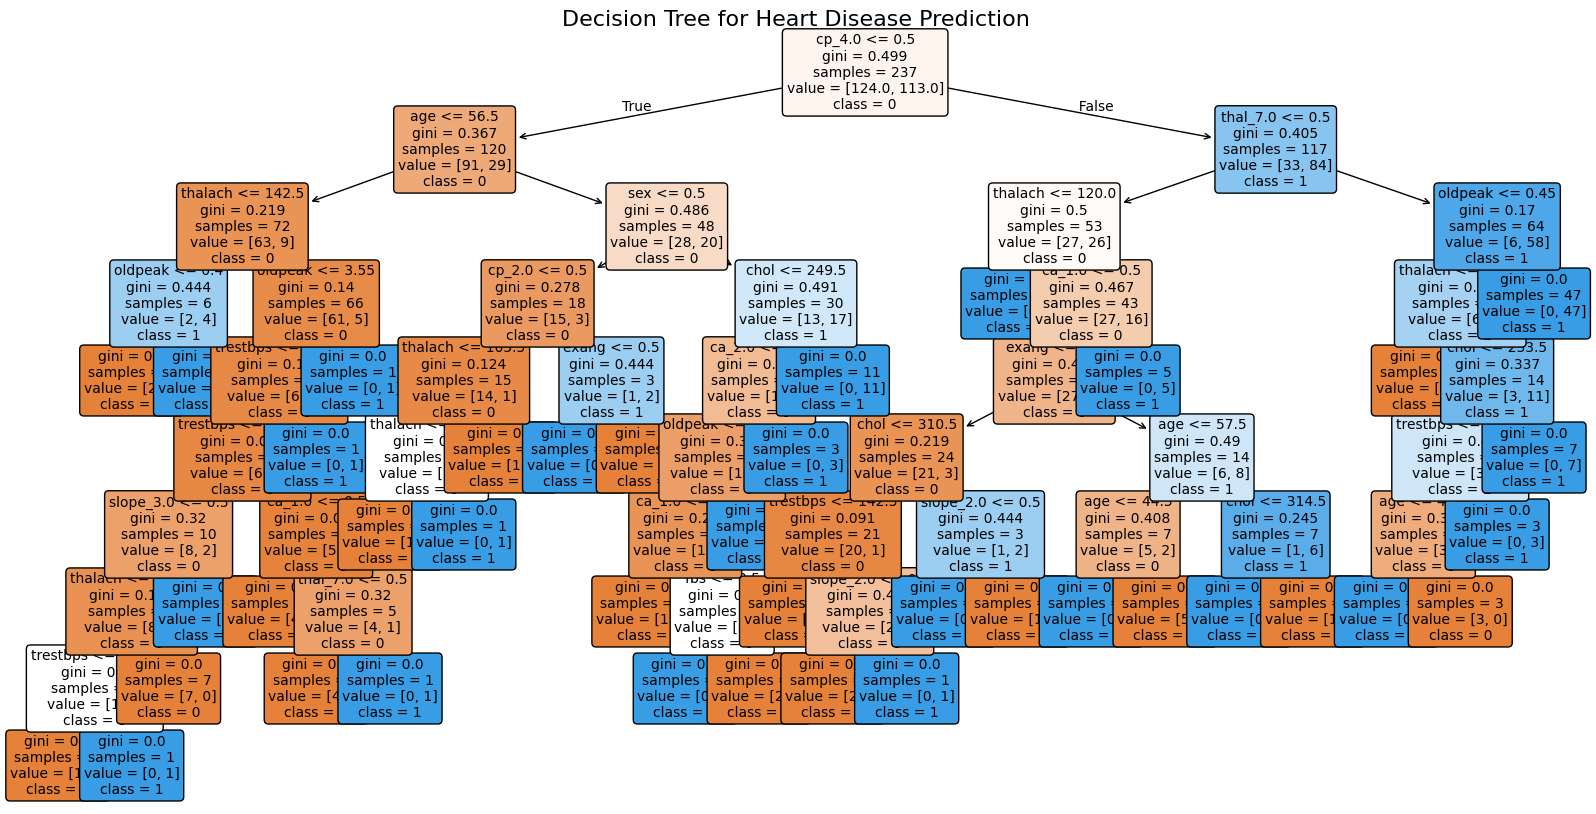

In [43]:
#  Get feature names after transformation
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Plot the Decision Tree
plt.figure(figsize=(20, 10))  # Set figure size for better readability
plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=[str(i) for i in sorted(y.unique())],  # Convert class labels to strings
    filled=True,  # Color nodes by class
    rounded=True,  # Rounded boxes for nodes
    fontsize=10   # Font size for readability
)
plt.title("Decision Tree for Heart Disease Prediction", fontsize=16)
plt.show()

Seeing how it actually performs on the Testing Dataset by using a **Confusion Matrix**

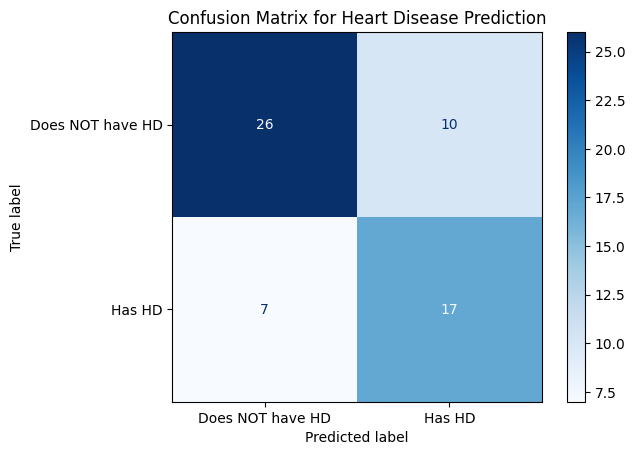

In [45]:
y_pred = dt_model.predict(X_test_transformed)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Does NOT have HD", "Has HD"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Heart Disease Prediction")
plt.show()

We see that a `26 + 10 = 36` did NOT have a **heart disease**, **26 (72.2%)** were correctly classified. \
Of the `7 + 17 = 24` that did have a **heart disease**, **17 (70.8)** were correctly classified \
We might have overfit the dataset, so we will try pruning the tree itself

### Cost Complexity Pruning

We will extract the different values of `alpha` that are available for this tree and build a pruned tree for each value of `alpha`

In [47]:
path = dt_model.cost_complexity_pruning_path(X_train, y_train) # determina Alpha values
ccp_alphas = path.ccp_alphas # extract different values of alpha
ccp_alphas = ccp_alphas[:-1] # exclude max val as it prunes everything

clf_dts = [] # list to add all the dec. trees into

# DT for each alpha added in the list
for ccp_alpha in ccp_alphas:
    dt_model = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt_model.fit(X_train, y_train)
    clf_dts.append(dt_model)

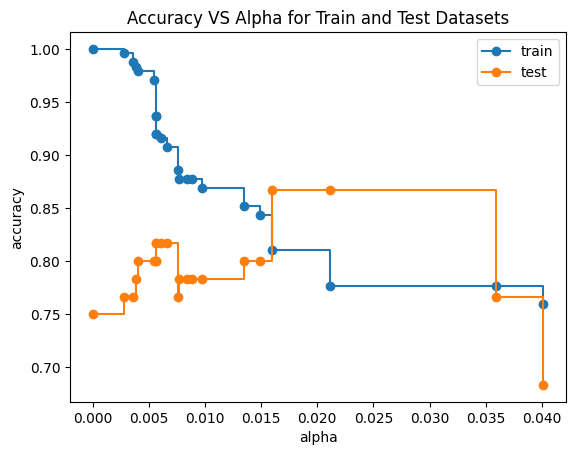

In [48]:
train_scores = [dt_model.score(X_train, y_train) for dt_model in clf_dts]
test_scores = [dt_model.score(X_test, y_test) for dt_model in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy VS Alpha for Train and Test Datasets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Accuracy of Test Data hits max at alpha $ \approx $ 0.016, so we will try to set it to that

Since, there are many ways that we could have divided the original dataset into Train and Test, there is no way to know that the current `alpha` we have is actually the best. 
So we will use **10-fold cross validation** 

### Cross Val for Finding Best Alpha

We will use different train and test datasets results in trees

<Axes: xlabel='tree'>

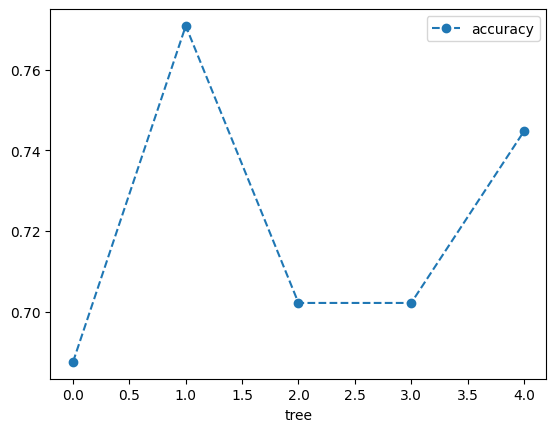

In [49]:
dt_model = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)

# 5-fold cross validation
scores = cross_val_score(dt_model, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

Using different **Training** and **Testing** data with same `alpha` resulted in different inaccuracies, suggesting that the `alpha` is sensitive to the datasets. So, instead of picking a single **Training** datatset and single **Testing** dataset, lets use Cross-Val to find the optimal value for `ccp_alpha`    

<Axes: xlabel='alpha'>

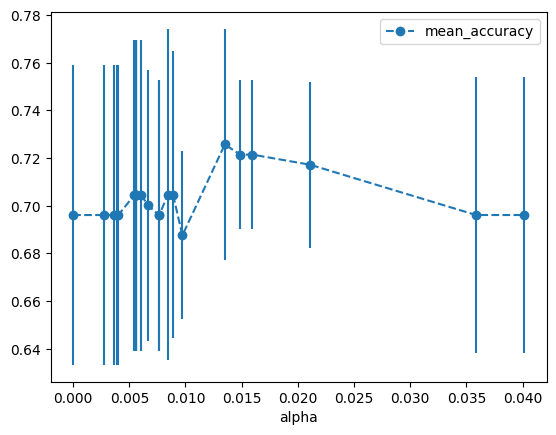

In [50]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    dt_model = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_model, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(
                    alpha_loop_values,
                    columns=['alpha', 'mean_accuracy', 'std']
                )

alpha_results.plot(
    x='alpha',
    y='mean_accuracy',
    yerr='std',
    marker='o',
    linestyle='--'
)

We can see that the value of `alpha` spikes somewhere between 0.13 and 0.15

In [51]:
alpha_results[
    (alpha_results['alpha'] > 0.013)
    &
    (alpha_results['alpha'] < 0.015)
]

,alpha,mean_accuracy,std
17,0.013502,0.725709,0.048292
18,0.014870,0.721454,0.031234


The value of `alpha` $ = $ 0.013502 is the best value and we will use it to build the tree

In [52]:
ideal_ccp_alpha = alpha_results[
    (alpha_results['alpha'] > 0.013)
    &
    (alpha_results['alpha'] < 0.014)
]
ideal_ccp_alpha

,alpha,mean_accuracy,std
17,0.013502,0.725709,0.048292


In [53]:
# Converting the Dataframe to the Float Value of Alpha that we require
ideal_ccp_alpha = float(ideal_ccp_alpha['alpha'].iloc[0])
ideal_ccp_alpha

0.013502109704641347

### Evaluating and Interpreting the Final DT

In [54]:
dt_model_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
dt_model_pruned = dt_model_pruned.fit(X_train, y_train)

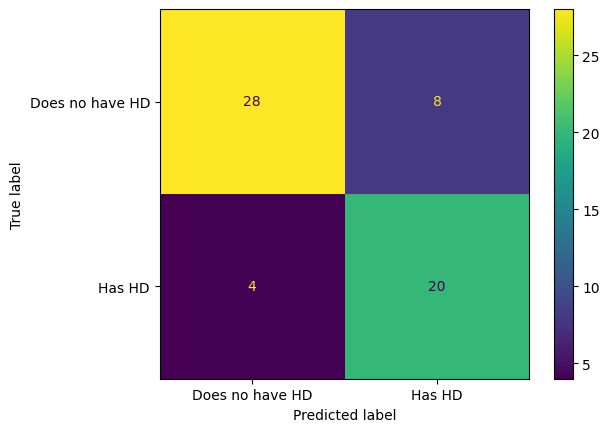

In [55]:
ConfusionMatrixDisplay.from_estimator(
    dt_model_pruned,
    X_test,
    y_test,
    display_labels = ["Does no have HD", "Has HD"]
)

We see that a `28 + 8 = 36` did NOT have a **heart disease**, **28 (77.77%)** were correctly classified. \
Of the `4 + 20 = 24` that did have a **heart disease**, **20 (83.33)** were correctly classified 


Compared to **PREVIOUSLY** \
`26 + 10 = 36` did NOT have a **heart disease**, **26 (72.2%)** were correctly classified. \
`7 + 17 = 24` that did have a **heart disease**, **17 (70.8)** were correctly classified 

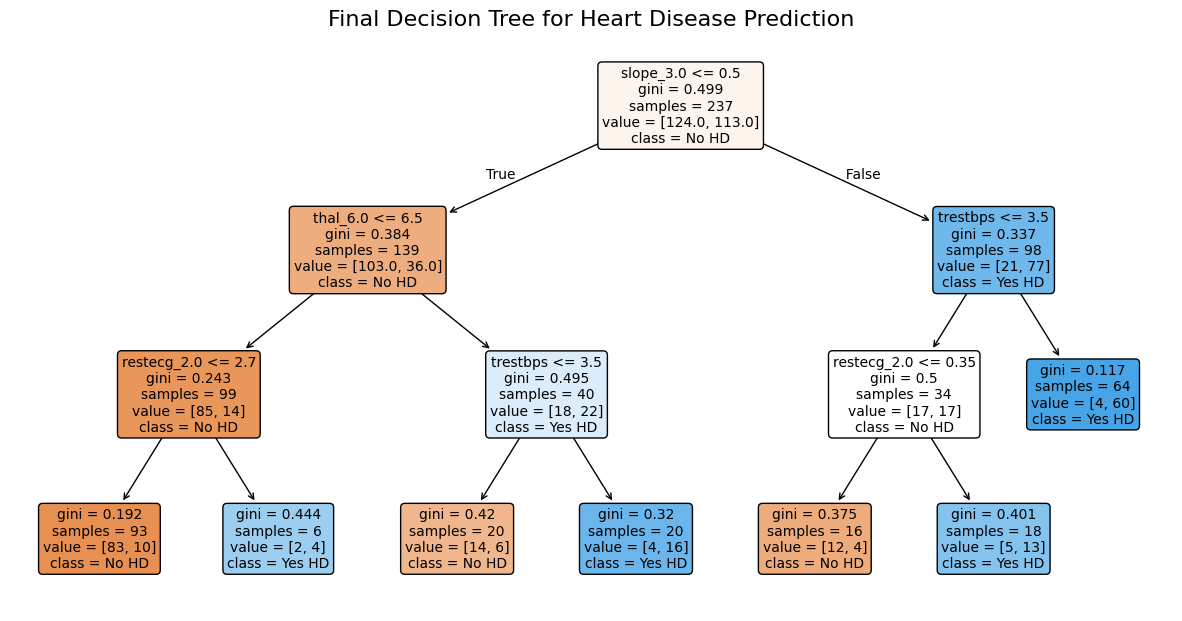

In [56]:
plt.figure(figsize=(15, 7.5))  # Set figure size for better readability
plot_tree(
    dt_model_pruned,
    feature_names=feature_names,
    class_names=["No HD", "Yes HD"],  # Convert class labels to strings
    filled=True,  # Color nodes by class
    rounded=True,  # Rounded boxes for nodes
    fontsize=10   # Font size for readability
)
plt.title("Final Decision Tree for Heart Disease Prediction", fontsize=16)
plt.show()

### MLOPs Part

In [37]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from pathlib import Path

In [38]:
if '__file__' in globals():
    project_root = Path(__file__).resolve().parents[1]
else:
    project_root = Path(os.getcwd()).parent  # fallback for Jupyter

mlflow_db_path = project_root / "mlruns" / "mlflow.db"
mlflow.set_tracking_uri(f"sqlite:///{mlflow_db_path}")
artifact_loc = f"file://{project_root}/mlruns/artifacts/"


In [39]:
print("MLflow URI:", mlflow.get_tracking_uri()) # Checking the path
print(f"Artifact Path: {artifact_loc}")
# print(f"sqlite:///{mlflow_db_path}")

MLflow URI: sqlite:////home/abandonedmonk/Work/MLOps-Zoomcamp-Project/mlruns/mlflow.db
Artifact Path: file:///home/abandonedmonk/Work/MLOps-Zoomcamp-Project/mlruns/artifacts/


In [40]:
# Creating Exp ID
experiment_id = mlflow.create_experiment(
    name="heart-disease",
    artifact_location=artifact_loc
)

2025/07/28 17:02:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/28 17:02:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [42]:
mlflow.set_tracking_uri(mlflow.get_tracking_uri())
mlflow.set_experiment(experiment_id=experiment_id)

with mlflow.start_run(run_name="DecisionTree_ccp_alpha_run"):
    model = DecisionTreeClassifier(ccp_alpha=ideal_ccp_alpha, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)

    mlflow.log_param("model_name", "Decision Tree Classifier")
    mlflow.log_param("ccp_alpha", ideal_ccp_alpha)

   # Calculate and log metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
    }
    mlflow.log_metrics(metrics)

    mlflow.set_tags({
        "developer": "Anshuman Jena",        
        "problem": "Heart Disease Detection",
        "type": "classification",
        "framework": "scikit-learn",
        "version": "v1",
        "stage": "experiment"
    })

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="HeartDiseaseDecisionTree",
        input_example=X_train[:5],
    )


/home/abandonedmonk/miniconda3/envs/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'HeartDiseaseDecisionTree'.
Created version '1' of model 'HeartDiseaseDecisionTree'.


#### Using other ML Algos

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


In [44]:
mlflow.set_tracking_uri(mlflow.get_tracking_uri())
mlflow.set_experiment("heart-disease")

with mlflow.start_run(run_name="RandomForestClassifier"):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mlflow.log_param("model_name", "Random Forest Classifier")

   # Calculate and log metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
    }
    mlflow.log_metrics(metrics)

    mlflow.set_tags({
        "developer": "Anshuman Jena",        
        "problem": "Heart Disease Detection",
        "type": "classification",
        "framework": "scikit-learn",
        "version": "v1",
        "stage": "experiment"
    })

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="HeartDiseaseRandomForest",
        input_example=X_train[:5],
    )

/home/abandonedmonk/miniconda3/envs/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'HeartDiseaseRandomForest'.
Created version '1' of model 'HeartDiseaseRandomForest'.


In [45]:
mlflow.set_tracking_uri(mlflow.get_tracking_uri())
mlflow.set_experiment("heart-disease")

with mlflow.start_run(run_name="HistGradientBoostingClassifier"):
    params = {
        "learning_rate":0.1,
        "max_iter":200,
        "max_leaf_nodes":31,
        "min_samples_leaf":10,
        "l2_regularization":0.1,
        "early_stopping":True,
        "random_state":42
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mlflow.log_param("model_name", "Hist Gradient Boosting Classifier")
    mlflow.log_params(params)

   # Calculate and log metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
    }
    mlflow.log_metrics(metrics)

    mlflow.set_tags({
        "developer": "Anshuman Jena",        
        "problem": "Heart Disease Detection",
        "type": "classification",
        "framework": "scikit-learn",
        "version": "v1",
        "stage": "experiment"
    })

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="HeartDiseaseHistGradientBoostingClassifier",
        input_example=X_train[:5],
    )


/home/abandonedmonk/miniconda3/envs/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'HeartDiseaseHistGradientBoostingClassifier'.
Created version '1' of model 'HeartDiseaseHistGradientBoostingClassifier'.


In [46]:
mlflow.set_tracking_uri(mlflow.get_tracking_uri())
mlflow.set_experiment("heart-disease")

with mlflow.start_run(run_name="LogisticRegression"):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mlflow.log_param("model_name", "Logistic Regression")

   # Calculate and log metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
    }
    mlflow.log_metrics(metrics)

    mlflow.set_tags({
        "developer": "Anshuman Jena",        
        "problem": "Heart Disease Detection",
        "type": "classification",
        "framework": "scikit-learn",
        "version": "v1",
        "stage": "experiment"
    })

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="HeartDiseaseLogisticRegression",
        input_example=X_train[:5],
    )

/home/abandonedmonk/miniconda3/envs/mlops/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/abandonedmonk/miniconda3/envs/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (traini

### Inferencing the best model

In [47]:
# Loading the preprocessed data directly for inferencing
processed_df = pd.read_csv("../data/processed/processed_cleveland_data.csv")
processed_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [48]:
# Independent Variables
X = df_with_no_missing.drop('hd', axis=1).copy()
X.head()

# Dependent Variables
y = df_with_no_missing['hd'].copy()
y.head()

# Making columns for preprocessing
numerical_cols = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak']
categorical_cols = ['restecg', 'slope', 'thal', 'ca', 'cp'] # We will pass this through OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),                  # Keep numerical columns as is
        ('cat', OneHotEncoder(drop='first'), categorical_cols)   # One-hot encode categorical columns
    ]
)

# Checking only heart disease and not severity
y_not_zero = y > 0
y[y_not_zero] = 1
y.unique()

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data using the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [49]:
import os
from pathlib import Path

if '__file__' in globals():
    project_root = Path(__file__).resolve().parents[1]
else:
    project_root = Path(os.getcwd()).parent  # fallback for Jupyter

mlflow_db_path = project_root / "mlruns" / "mlflow.db"
mlflow.set_tracking_uri(f"sqlite:///{mlflow_db_path}")

In [ ]:
print("MLflow URI:", mlflow.get_tracking_uri()) # Checking the path
print(f"sqlite:///{mlflow_db_path}")

MLflow URI: sqlite:////home/abandonedmonk/Work/MLOps-Zoomcamp-Project/mlruns/mlflow.db
sqlite:////home/abandonedmonk/Work/MLOps-Zoomcamp-Project/mlruns/mlflow.db


In [50]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import mlflow

import pprint

mlflow.set_tracking_uri(mlflow.get_tracking_uri())
mlflow.set_experiment(experiment_id=experiment_id)

client = MlflowClient()

# Retrieve the top_n model runs and log the models
# experiment = client.get_experiment_by_name("heart-disease")
# runs = client.search_runs(
#         experiment_ids=experiment.experiment_id,
#         run_view_type=ViewType.ACTIVE_ONLY,
#         max_results=top_n,
#         order_by=["metrics.rmse ASC"]
#     )
# for run in runs:
#     train_and_log_model(data_path=data_path, params=run.data.params)

    # Select the model with the lowest test RMSE
experiment = client.get_experiment_by_name("heart-disease")
best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.accuracy DESC"]
    )[0]

pprint.pprint(best_run)

<Run: data=<RunData: metrics={'accuracy': 0.8666666666666667,
 'f1_score': 0.8674285714285713,
 'precision': 0.8701357466063349,
 'recall': 0.8666666666666667}, params={'model_name': 'Logistic Regression'}, tags={'developer': 'Anshuman Jena',
 'framework': 'scikit-learn',
 'mlflow.log-model.history': '[{"run_id": "31abdf45748545a7a1bd7cf662155510", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2025-07-28 11:32:52.052003", "flavors": '
                             '{"python_function": {"model_path": "model.pkl", '
                             '"predict_fn": "predict", "loader_module": '
                             '"mlflow.sklearn", "python_version": "3.12.11", '
                             '"env": {"conda": "conda.yaml", "virtualenv": '
                             '"python_env.yaml"}}, "sklearn": '
                             '{"pickled_model": "model.pkl", '
                             '"sklearn_version": "1.4.2", '

In [51]:
loaded_model = mlflow.sklearn.load_model(f"runs:/31abdf45748545a7a1bd7cf662155510/model")
loaded_model.fit(X_train, y_train)

/home/abandonedmonk/miniconda3/envs/mlops/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [52]:
import pickle
with open("../models/model.bin", 'wb') as f_out:
    pickle.dump(loaded_model, f_out)
print(f"Model saved to {"../models/model.bin"}")

Model saved to ../models/model.bin


### Downloading with grace 

In [ ]:
import os
import pickle
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from typing import Tuple, Dict
from datetime import date


def load_model(
    paths: Dict,
    save_dir: str = "../models/"
) -> Tuple[str, str]:
    """
    Loads the latest model and preprocessor from MLflow, and saves both in one pickle file.

    Parameters:
    ----------
    model_name : str
        Name of the registered model (e.g., "best_model_2025-07-28")
    experiment_name : str
        Name of the MLflow experiment
    save_dir : str
        Directory where combined .pkl file will be saved

    Returns:
    -------
    str
        Path to saved combined .pkl file
    """

    assert isinstance(paths["model_name"], str), "model_name must be a string"
    assert isinstance(paths["experiment_name"], str), "experiment_name must be a string"

    # Ensure tracking URI is set
    mlflow.set_tracking_uri(paths["mlflow_db_path"])
    client = MlflowClient()

    # Get latest version of registered model and preprocessor
    versions = client.get_latest_versions(name=paths["model_name"])
    latest_model = versions[0] if versions else None
    model_uri = f"models:/{paths["model_name"]}/{latest_model.version}"

    preprocessor_versions = client.get_latest_versions(name="Preprocessor")
    latest_preprocessor = preprocessor_versions[0] if preprocessor_versions else None
    preprocessor_uri = f"models:/Preprocessor/{latest_preprocessor.version}"  # Adjust path if needed

    # Load artifacts using MLflow
    print(f"📦 Downloading model from {model_uri}")
    model = mlflow.sklearn.load_model(model_uri)

    print(f"📦 Downloading preprocessor from {preprocessor_uri}")
    preprocessor = mlflow.sklearn.load_model(preprocessor_uri)

    # Ensure output directory exists
    os.makedirs(save_dir, exist_ok=True)

    combined_path = os.path.join(save_dir, "pipeline_bundle.pkl")

    with open(combined_path, "wb") as f:
        pickle.dump({"model": model, "preprocessor": preprocessor}, f)

    print(f"✅ Combined model + preprocessor saved at: {combined_path}")



In [81]:
paths = {
        "mlflow_db_path": f"sqlite:///{project_root}/mlruns/mlflow.db",
        "artifact_loc": f"file://{project_root}/mlruns/artifacts/",
        "experiment_name": "heart-disease-experiment",
        "model_name": "best_model_2025-07-28"
    }

In [82]:
load_model(paths)

Latest Preprocessor: [] <ModelVersion: aliases=[], creation_timestamp=1753727005872, current_stage='None', description=None, last_updated_timestamp=1753727005872, name='Preprocessor', run_id='40012f9379b24907ba9bd956af9d56f0', run_link=None, source='/home/abandonedmonk/Work/MLOps-Zoomcamp-Project/mlruns/2/40012f9379b24907ba9bd956af9d56f0/artifacts/preprocessor', status='READY', status_message=None, tags={}, user_id=None, version=2>
📦 Downloading model from models:/best_model_2025-07-28/3
📦 Downloading preprocessor from models:/Preprocessor/2
✅ Combined model + preprocessor saved at: ../models/pipeline_bundle.pkl


/tmp/ipykernel_26208/2582604984.py:23: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(name=paths["model_name"])
/tmp/ipykernel_26208/2582604984.py:27: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  preprocessor_versions = client.get_latest_versions(name="Preprocessor")


In [3]:
pip install pandas numpy scikit-learn xgboost matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='files.pythonhosted.org', port=443): Max retries exceeded with url: /packages/00/5a/f43bad68b31269a72bdd66102732ea4473e98f421ee9f71379e35dcb56f5/xgboost-3.0.5-py3-none-win_amd64.whl.metadata (Caused by NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x00000218A2EB2420>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))



In [1]:
# --- XGBoost Heart Disease Model Training ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pickle

# Load dataset
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

data = pd.read_csv("cleveland.data", header=None, names=column_names, na_values='?')

# Drop missing values
data.dropna(inplace=True)

# Encode categorical columns
label_enc = LabelEncoder()
for col in ['cp', 'restecg', 'slope', 'thal']:
    data[col] = label_enc.fit_transform(data[col])

# Prepare features and target
X = data.drop('target', axis=1)
y = data['target'].apply(lambda x: 1 if x > 0 else 0)  # Convert multiclass to binary

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train XGBoost model
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100
)
model.fit(X_train, y_train)

# Save the model as .pkl
with open("xgboost_heart_disease.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model training complete. File saved as 'xgboost_heart_disease.pkl'")


ModuleNotFoundError: No module named 'xgboost'